In [1]:
%matplotlib inline
import pennylane as qml
import numpy as np
import jax
import jax.numpy as jnp
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.labelsize'] = 15

### Build a simple circuit

In [2]:
num_qubits, num_layers = 4, 2
device = qml.device('default.qubit', wires=num_qubits)
@qml.qnode(device, interface='jax', diff_method='backprop')
def circuit(parameters, out=None):
    qml.StronglyEntanglingLayers(parameters, wires=range(num_qubits))
    if out == None:
        return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]
    elif out == 'state':
        return qml.state()
    elif out == 'vn_entropy':
        return qml.vn_entropy(wires=range(num_qubits // 2))

### How to run the circuit

In [3]:
key = jax.random.PRNGKey(42)
shape = qml.StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=num_qubits)
params = jax.random.uniform(key, shape, minval=0., maxval=2*jnp.pi)
circuit(params)

DeviceArray([ 0.116687  , -0.14842626,  0.35659492, -0.21517494], dtype=float32)

### Circuit diagram

In [4]:
print(qml.draw(circuit, expansion_strategy="device", max_length=400)(params))

0: ──Rot(4.56,5.36,6.18)─╭●───────╭X──Rot(2.08,2.87,5.08)─╭●────╭X────┤  <Z>
1: ──Rot(0.52,0.21,3.01)─╰X─╭●────│───Rot(6.03,0.42,4.65)─│──╭●─│──╭X─┤  <Z>
2: ──Rot(1.08,4.34,3.79)────╰X─╭●─│───Rot(2.11,2.92,2.45)─╰X─│──╰●─│──┤  <Z>
3: ──Rot(5.09,5.41,5.70)───────╰X─╰●──Rot(0.73,5.39,1.40)────╰X────╰●─┤  <Z>


### Define a loss function and optimize it

In [5]:
key = jax.random.PRNGKey(0)
target = jax.random.uniform(key, (num_qubits,), minval=-1, maxval=1)
@jax.jit  # massive speedup!
def loss(params):
    return jnp.sum(circuit(params))

In [6]:
key = jax.random.PRNGKey(0)
initializations = jax.random.uniform(key, (1000, num_layers, num_qubits, 3), minval=0., maxval=2*jnp.pi)

In [7]:
def do_optimization(initializations, noise=None, step_size=0.2, seed=0):
    results = []
    key = jax.random.PRNGKey(seed)
    for ini in initializations:
        loss_history, grad_history, param_history = [], [], [ini]
        for _ in tqdm(range(200)):
            p = param_history[-1]
            l, g = jax.value_and_grad(loss)(p)
            if noise is None:
                param_history.append(p - step_size*g)
            else:
                k, key = jax.random.split(key)
                perturbation = jax.random.uniform(key, p.shape, minval=-1, maxval=1)
                param_history.append(p - step_size*g + noise * perturbation)
            loss_history.append(l)
            grad_history.append(g)
            if jnp.linalg.norm(g) / g.size < 1e-4:
                break
        results.append((loss_history, grad_history, param_history))
    return results

In [8]:
results = do_optimization(initializations[:30])

 26%|███████████████████████████████▊                                                                                        | 53/200 [00:01<00:03, 42.89it/s]


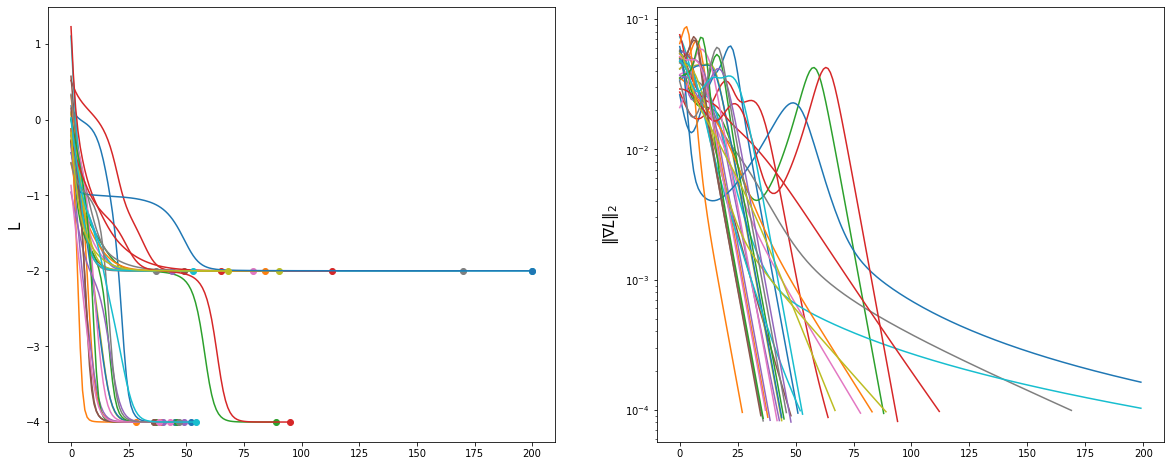

In [9]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
c = plt.get_cmap('tab10').colors
for i, (lh, gh, ph) in enumerate(results):
    i = i % len(c)
    ax1.plot(lh, color=c[i])
    ax1.plot(len(lh), lh[-1], 'o', color=c[i])
    ax1.set_ylabel('L')
    ax2.plot([jnp.linalg.norm(g) / g.size for g in gh])
    ax2.semilogy()
    ax2.set_ylabel(r'$\Vert \nabla L\Vert_2$')

### See how close the final points are to each other

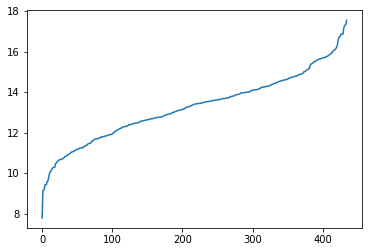

In [10]:
final_points = [r[2][-1] for r in results]
L = len(results)
distances = []
for i in range(L):
    for j in range(i+1, L):
        distances.append(np.linalg.norm(final_points[i] - final_points[j]))
plt.plot(np.sort(distances))

### Pick the ones with a long plateau

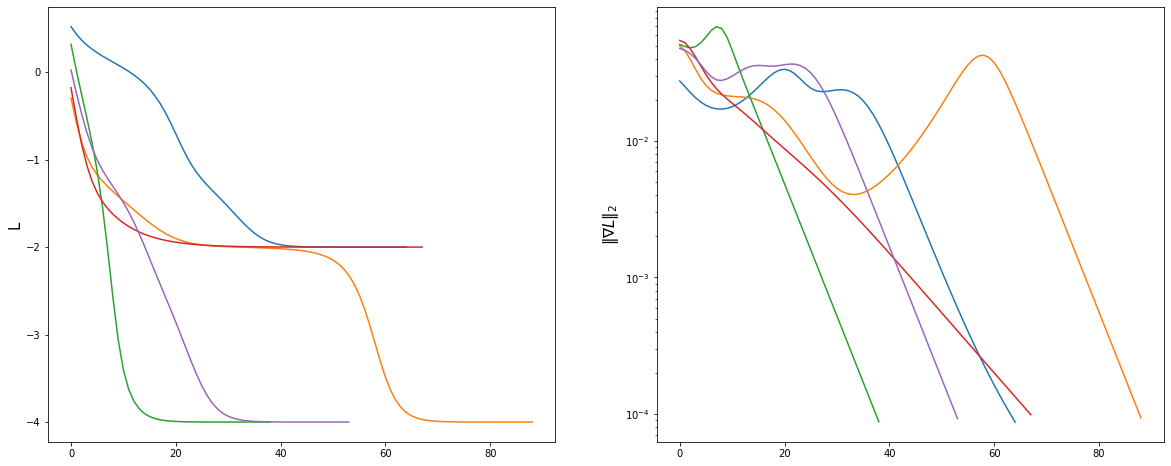

In [11]:
history_lengths = [len(c[0]) for r in results]
selection = np.argsort(history_lengths)[-5:]
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
for i in selection:
    lh, gh, ph = results[i]
    ax1.plot(lh)
    ax1.set_ylabel('L')
    ax2.plot([jnp.linalg.norm(g) / g.size for g in gh])
    ax2.semilogy()
    ax2.set_ylabel(r'$\Vert \nabla L\Vert_2$')

### Compute the Hessian's spectra

In [12]:
hessian_eigs = []
for s in selection:
    lh, gh, ph = results[s]
    h_eigs = []
    for p in tqdm(ph):
        h = jax.hessian(loss)(p)
        flat_dims = num_layers * num_qubits * 3
        eig, _ = jnp.linalg.eig(h.reshape(flat_dims, flat_dims))
        h_eigs.append(jnp.sort(eig.real))
    hessian_eigs.append(jnp.array(h_eigs))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 22.41it/s]


### A siginificant amout of eigenvalues are 'zero'

[]

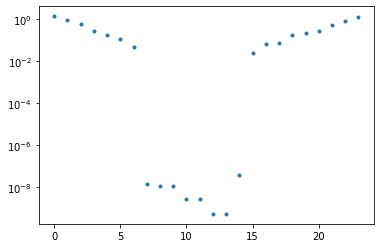

In [13]:
plt.plot(jnp.abs(h_eigs[0]), '.')
plt.semilogy()

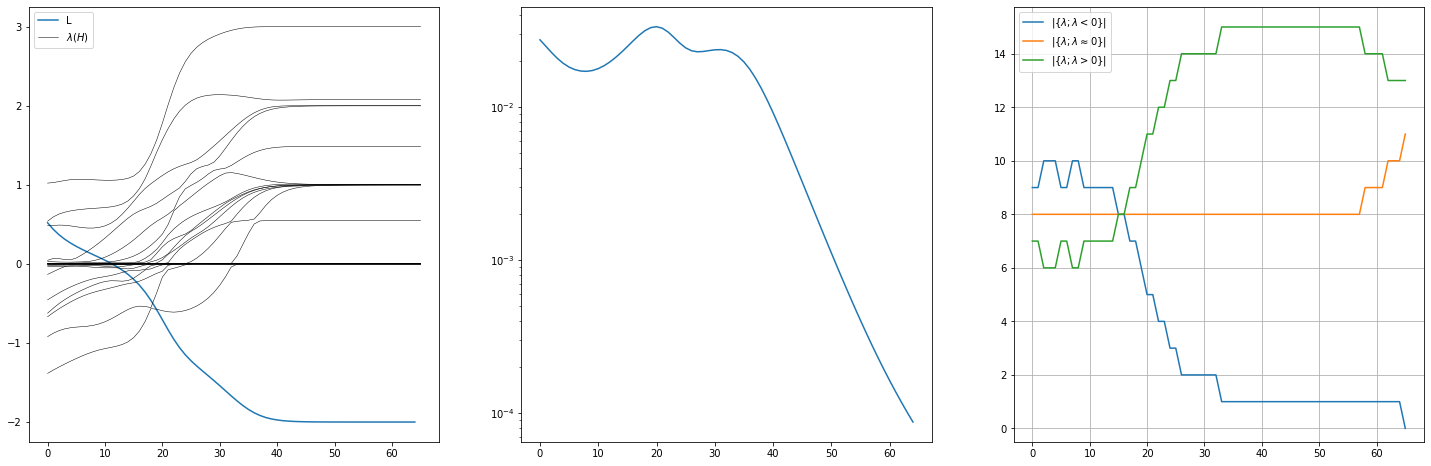

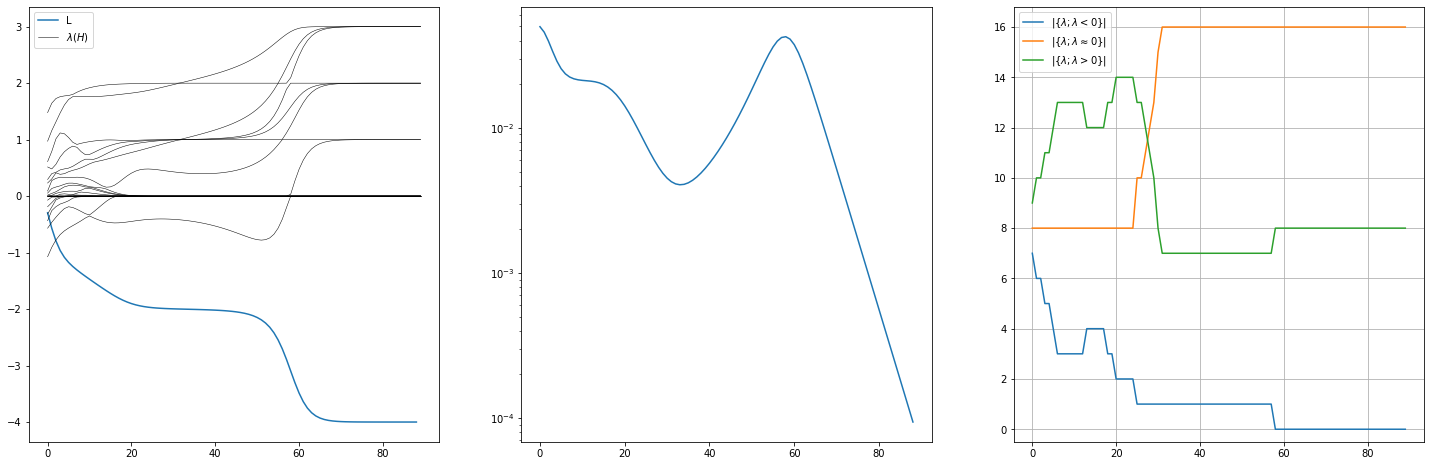

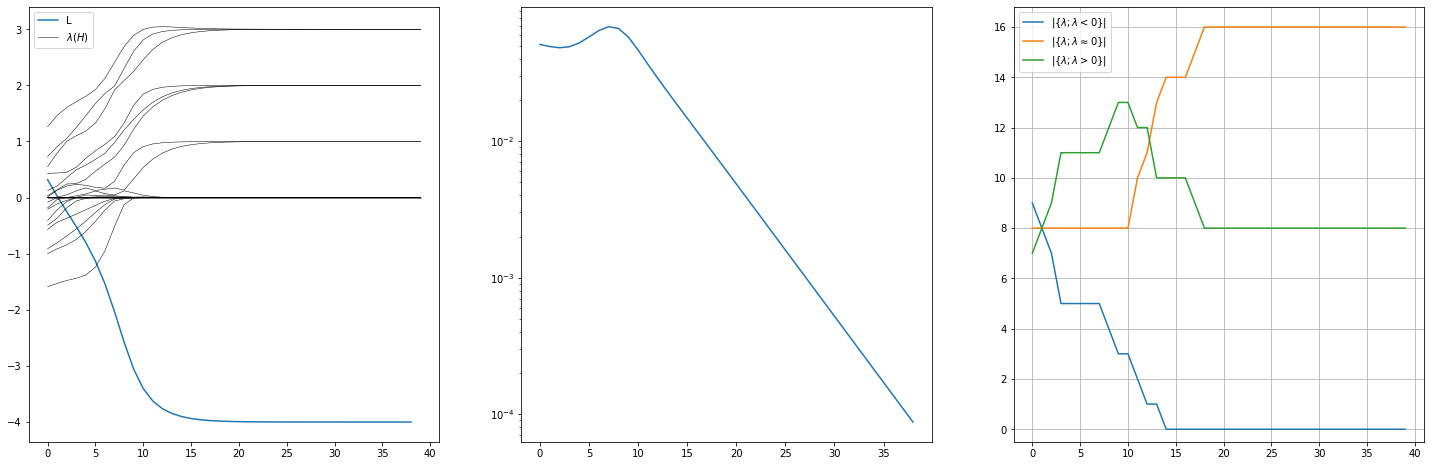

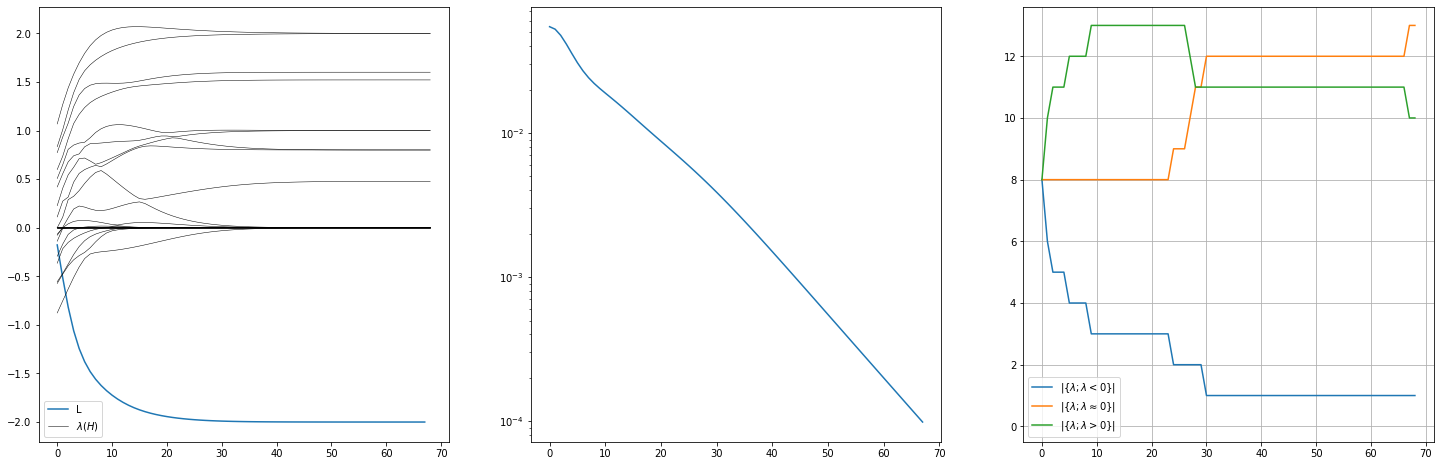

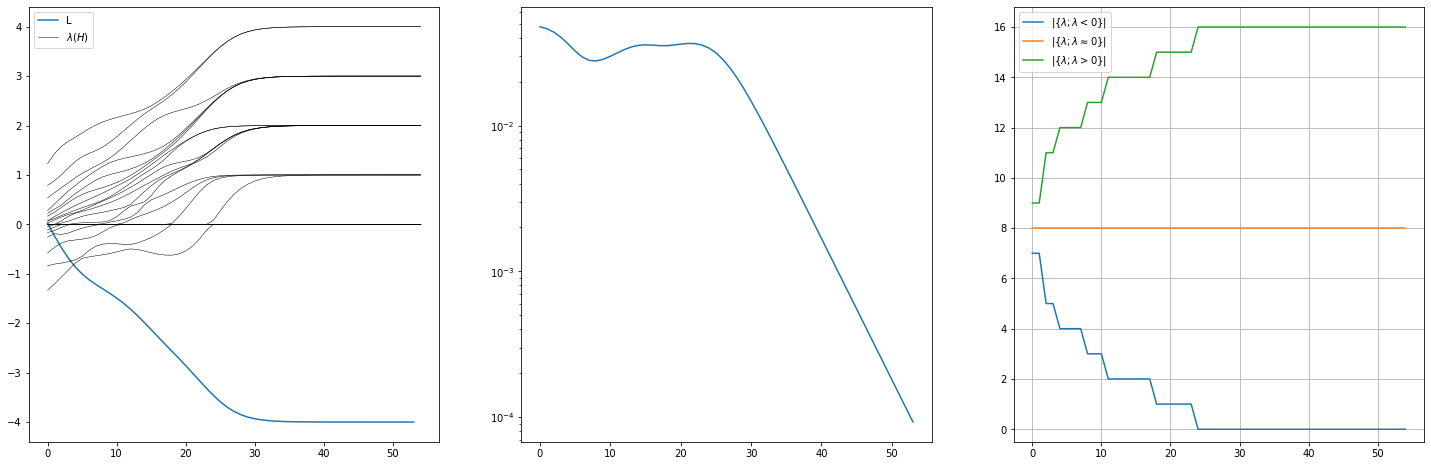

In [14]:
for i, s in enumerate(selection):
    lh, gh, ph = results[s]
    h_eigs = hessian_eigs[i]
    _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))
    ax1.plot(lh)
    ax1.plot(h_eigs, linewidth=.5, color='black')
    ax1.legend(['L', r'$\lambda(H)$'])
    num_signs = []
    for eigs in h_eigs:
        pos = jnp.sum(eigs > 1e-5)
        neg = jnp.sum(eigs < -1e-5)
        zero = len(eigs) - pos - neg
        num_signs.append([neg, zero, pos])
    ax2.plot([jnp.linalg.norm(g) / g.size for g in gh])
    ax3.plot(jnp.array(num_signs))
    ax3.set_ylim(bottom=-.5)
    ax3.grid(True)
    ax3.legend([
        r'$\vert\lbrace\lambda; \lambda<0 \rbrace\vert$',
        r'$\vert\lbrace\lambda; \lambda\approx 0 \rbrace\vert$',
        r'$\vert\lbrace\lambda; \lambda>0 \rbrace\vert$'
    ])
    ax2.semilogy()
    plt.show()

### Repeat optimization for selected examples with noise

In [15]:
noise_results = do_optimization(initializations[selection], noise=0.1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 43.54it/s]


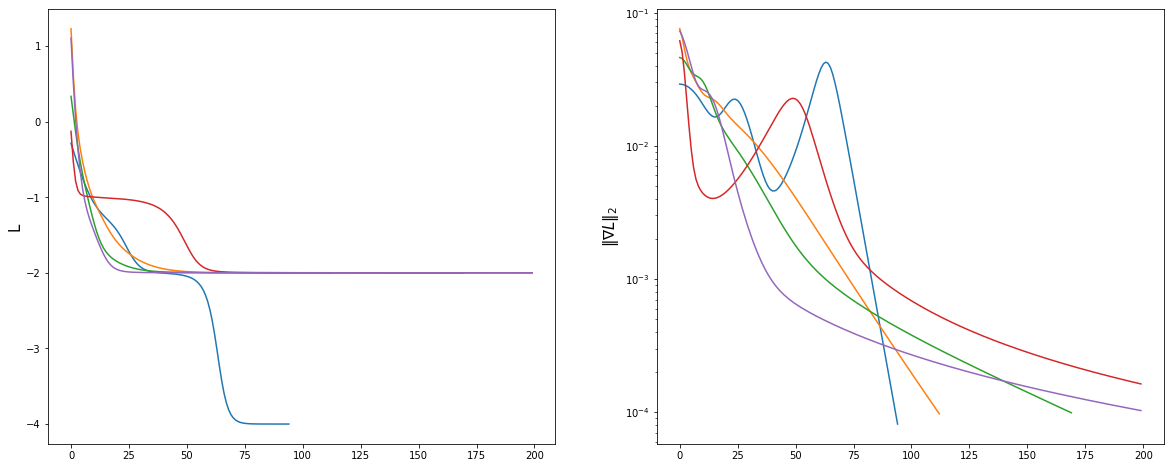

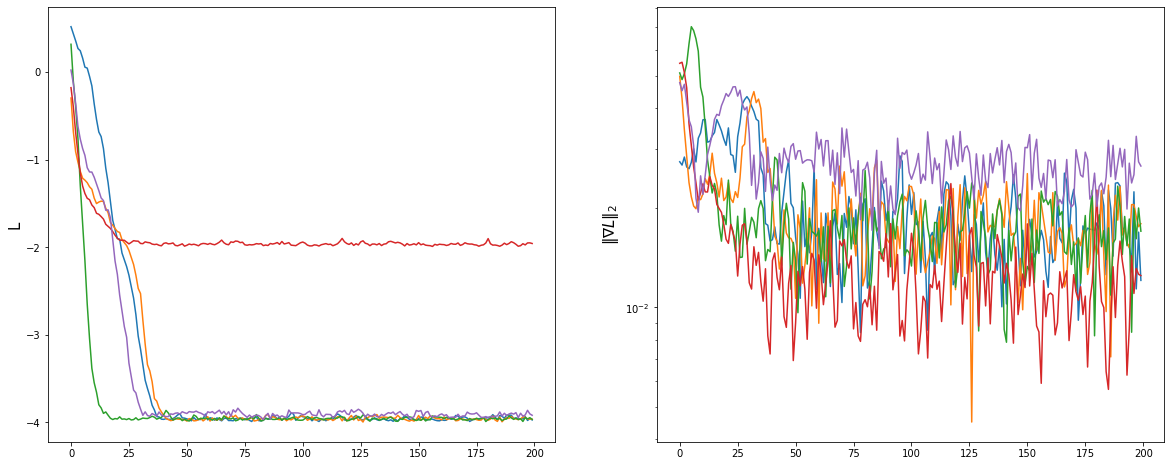

In [16]:
history_lengths = [len(r[0]) for r in results]
selection = np.argsort(history_lengths)[-5:]
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
for i in selection:
    lh, gh, ph = results[i]
    ax1.plot(lh)
    ax1.set_ylabel('L')
    ax2.plot([jnp.linalg.norm(g) / g.size for g in gh])
    ax2.semilogy()
    ax2.set_ylabel(r'$\Vert \nabla L\Vert_2$')
plt.show()
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
for c in noise_results:
    lh, gh, ph = c
    ax1.plot(lh)
    ax1.set_ylabel('L')
    ax2.plot([jnp.linalg.norm(g) / g.size for g in gh])
    ax2.semilogy()
    ax2.set_ylabel(r'$\Vert \nabla L\Vert_2$')

In [17]:
hessian_eigs_noise = []
for r in noise_results:
    lh, gh, ph = r
    h_eigs = []
    for p in tqdm(ph):
        h = jax.hessian(loss)(p)
        flat_dims = num_layers * num_qubits * 3
        eig, _ = jnp.linalg.eig(h.reshape(flat_dims, flat_dims))
        h_eigs.append(jnp.sort(eig.real))
    hessian_eigs_noise.append(jnp.array(h_eigs))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:09<00:00, 22.25it/s]


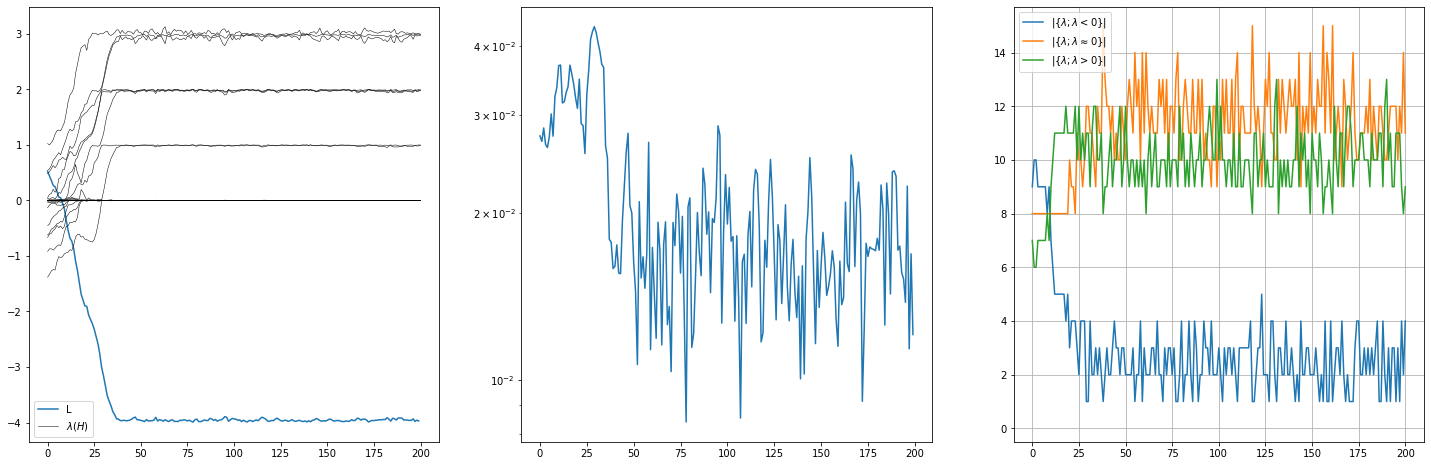

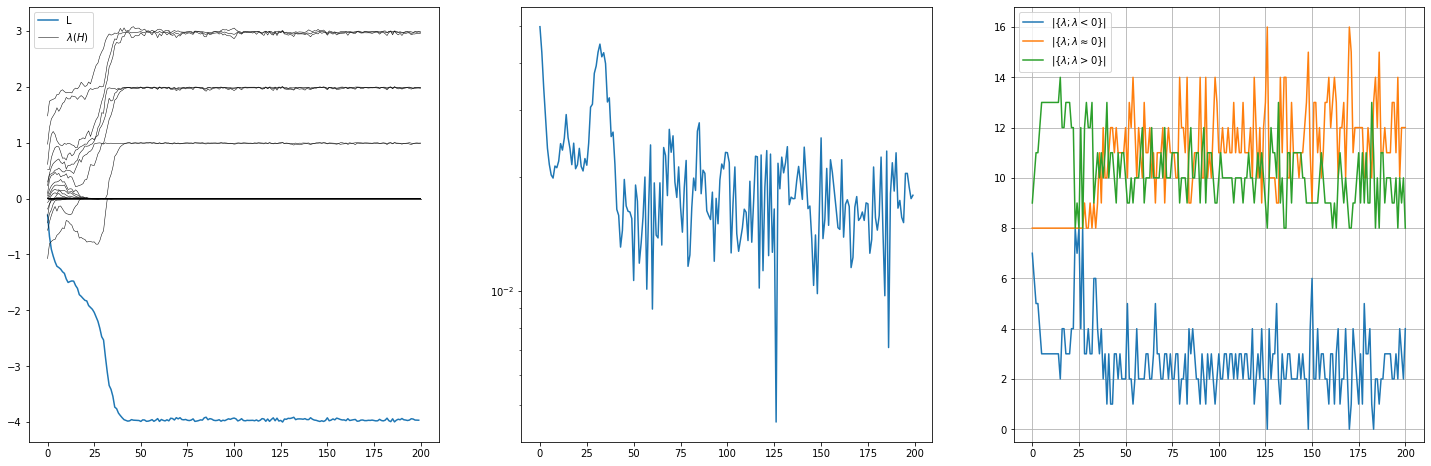

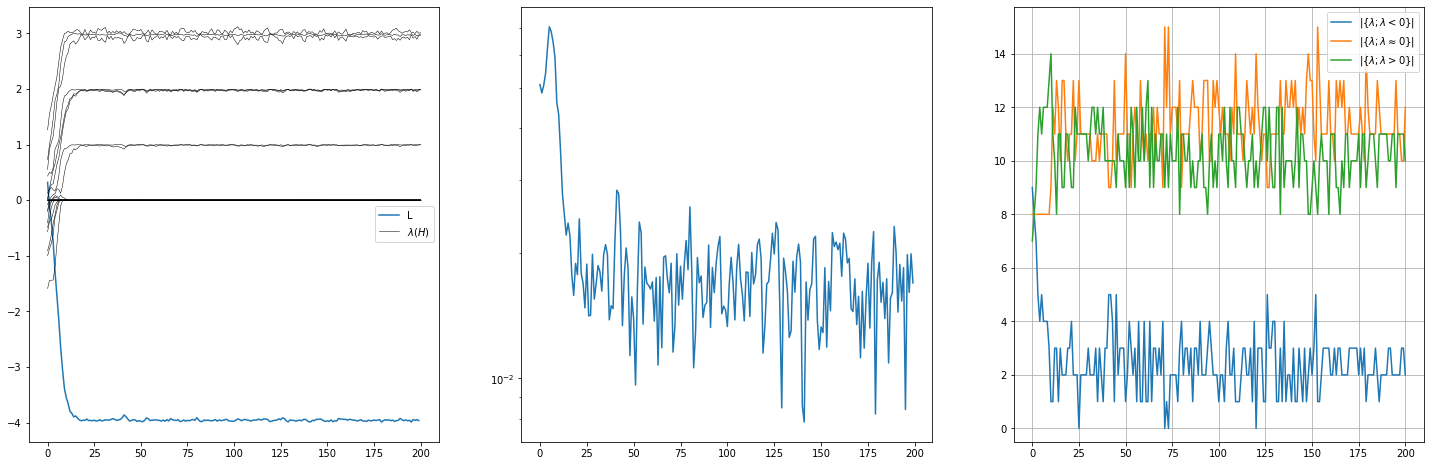

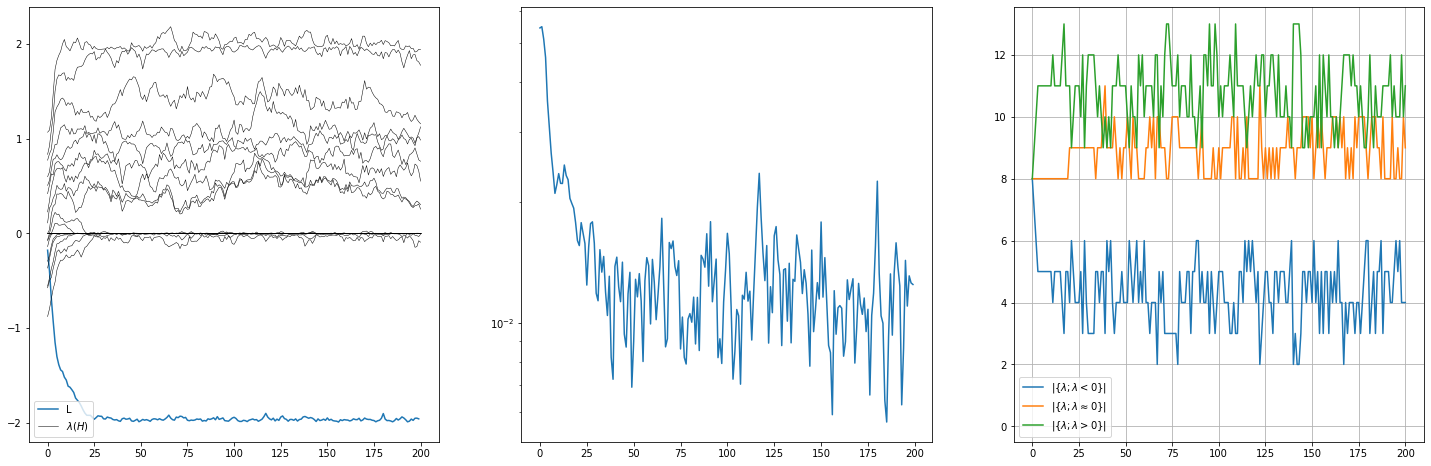

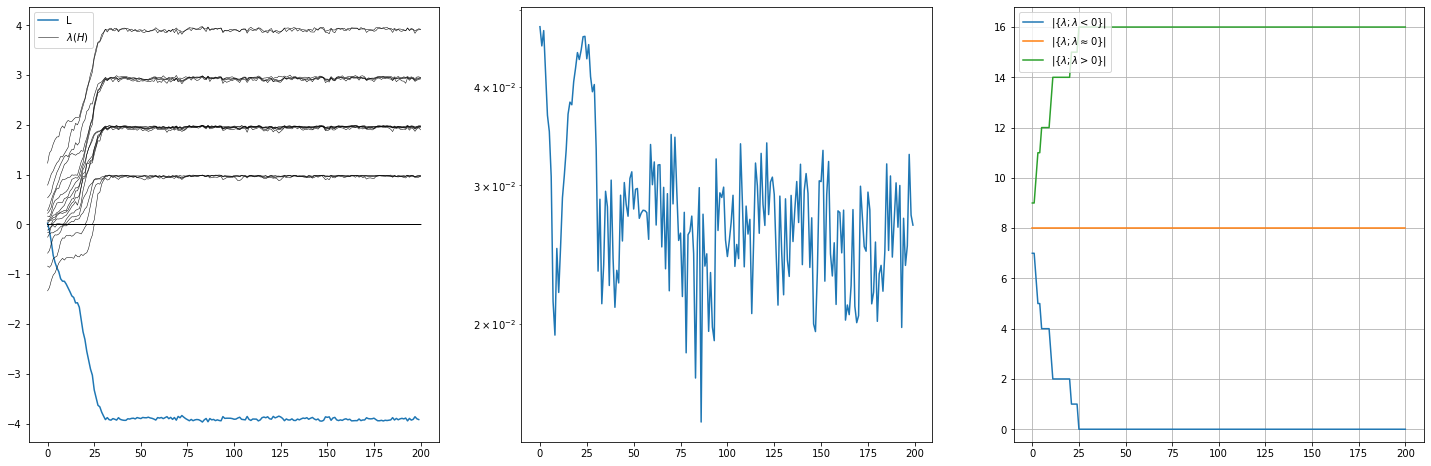

In [18]:
for i, r in enumerate(noise_results):
    lh, gh, ph = r
    h_eigs = hessian_eigs_noise[i]
    _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))
    ax1.plot(lh)
    ax1.plot(h_eigs, linewidth=.5, color='black')
    ax1.legend(['L', r'$\lambda(H)$'])
    num_signs = []
    for eigs in h_eigs:
        pos = jnp.sum(eigs > 1e-5)
        neg = jnp.sum(eigs < -1e-5)
        zero = len(eigs) - pos - neg
        num_signs.append([neg, zero, pos])
    ax2.plot([jnp.linalg.norm(g) / g.size for g in gh])
    ax3.plot(jnp.array(num_signs))
    ax3.set_ylim(bottom=-.5)
    ax3.grid(True)
    ax3.legend([
        r'$\vert\lbrace\lambda; \lambda<0 \rbrace\vert$',
        r'$\vert\lbrace\lambda; \lambda\approx 0 \rbrace\vert$',
        r'$\vert\lbrace\lambda; \lambda>0 \rbrace\vert$'
    ])
    ax2.semilogy()
    plt.show()